# Calculating NDWI and Compared it to WOFS  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat Collection 2 surface reflectance and shows water detected for selected areas of Africa.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

## Description
This notebook explains both the structure of the WOFLs, and how you can use WOfS derived product to perform accuracy assessment of the product using ground truth dataset.

The data in a WOFL is stored as a bit field. 
This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc).
In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

The notebook demonstrates how to:

1. Load WOFL data for a given location and time period 
2. Inspect the WOFL bit flag information
3. Use the WOFL bit flags to create a binary mask
4. Apply WOFL-based masks to fractional cover dataset 
5. Generating a confusion error matrix for WOFL classification
6. Assessing the accuracy of the classification 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

`Steps to take include:` 
- Load both Landsat8 and Sentinel-2 dataset over part of Africa, Lake Sulunga and calculate NDWI and MNDWI indeces 
- Load WOFS for the same region and compare two results in a quantitive way (Graphs)

### Load packages

In [1]:
%matplotlib inline

import datacube
from datacube.utils import masking 
import sys
import os
import dask 
import rasterio
import xarray
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard
from rasterio.mask import mask


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Applying_WOfS")

### Analysis parameters

In [12]:
#Site location in Tanzania close to the border with Kenya
#change the location to somewhere in Ghana 
lat, lon =  -6.083 ,35.184
buffer = 0.2

x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2019-01-01', '2019-03-20'),
    'resolution': (-30, 30)
}

output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2', query=query) #use the collection 2 one here that should have 2018

#automatically detect the number of cpus
ncpus=int(float(sp.getoutput('env | grep CPU')[-3:]))


### View the selected location

In [13]:
display_map(x=x, y=y)

## Calcuate NDWI and MDNWI indices 

## Load WOFL data


To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [14]:
# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2", output_crs=output_crs, group_by="solar_day",
                            fuse_func=wofs_fuser, **query)

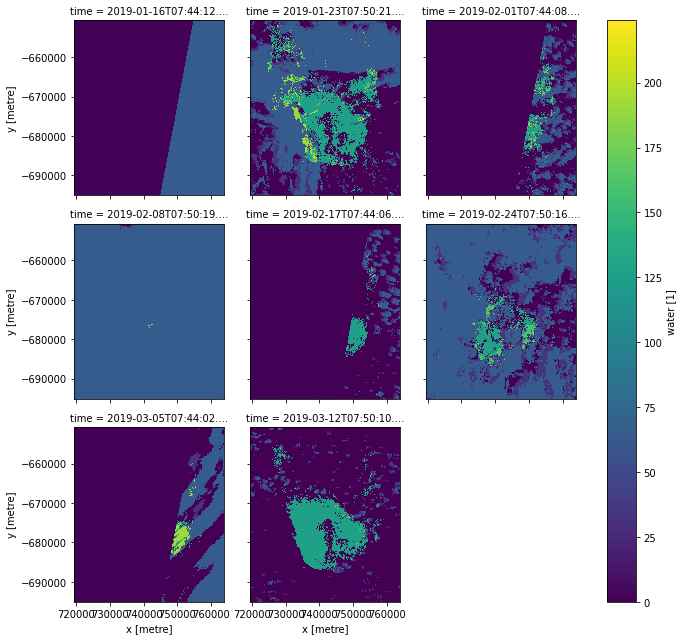

In [15]:
# Plot the loaded WOFLs
wofls.water.plot(col="time", col_wrap=3)
plt.show()

In [24]:
# Select one image of interest (`time=2` selects the third observation)
wofl = wofls.isel(time=7)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [25]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
contiguous,1,"{'0': True, '1': False}",Contiguity
sea,2,"{'0': False, '1': True}",Sea
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


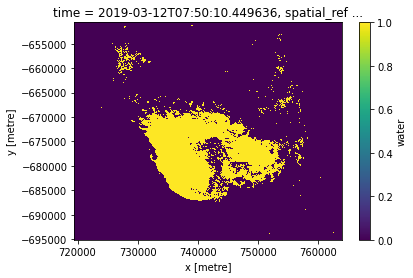

In [26]:
# Show areas flagged as water only (with no other flags set)
(wofl.water == 128).plot.imshow()
plt.show()

We can convert the WOFL bit field into a binary array containing True and False values. This allows us to use the WOFL data as a mask that can be applied to other datasets.
The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above. For more details on how to do masking on WOfS, see the [Applying_WOfS_bit_masking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)